# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [ ]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

Mounted at /content/drive/
ls: cannot access '/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/': No such file or directory


In [ ]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Populating namespaces

In [ ]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
# Set image dimensions (adjust based on your dataset)
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 10

# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

print(f"Image dimensions: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training epochs: {EPOCHS}")
print(f"Data paths configured successfully!")

Image dimensions: 128x128
Batch size: 32
Training epochs: 10
Data paths configured successfully!


## Prepare DataSet

### *Download* DataSet

In [ ]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 14:53:56--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.165.102.96, 3.165.102.109, 3.165.102.59, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.165.102.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   196MB/s    in 1.7s    

2025-10-05 14:53:58 (196 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  sample_data


In [ ]:
# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['Infected', 'Uninfected']
)

test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['Infected', 'Uninfected']
)

print("Data generators created successfully!")
print(f"Training samples: {train_generator.samples}")
print(f"Testing samples: {test_generator.samples}")

# Izere Uwonkunda Kerie

#### ResNet50 Pre-trained Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import os


In [ ]:
results_table = pd.DataFrame(columns=[
    'Experiment',
    'Description',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'AUC'
])

print("Results tracking table created")
print(results_table)

Results tracking table created
Empty DataFrame
Columns: [Experiment, Description, Accuracy, Precision, Recall, F1-Score, AUC]
Index: []


#### Split data function


In [ ]:
# Define the split_data function (copied from cell JgIa4VFBpo5n)
def split_data():
    """Split data into train/test sets (80/20 split)"""
    # Source directories
    infected_dir = os.path.join(cell_images_dir, 'Parasitized')
    uninfected_dir = os.path.join(cell_images_dir, 'Uninfected')

    print(f"Looking for data in:")
    print(f"Infected: {infected_dir}")
    print(f"Uninfected: {uninfected_dir}")

    # Get all image files
    infected_images = [f for f in os.listdir(infected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    uninfected_images = [f for f in os.listdir(uninfected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Found {len(infected_images)} infected images")
    print(f"Found {len(uninfected_images)} uninfected images")

    # Shuffle the lists
    random.shuffle(infected_images)
    random.shuffle(uninfected_images)

    # Calculate split indices
    infected_split = int(0.8 * len(infected_images))
    uninfected_split = int(0.8 * len(uninfected_images))

    # Split infected images
    for i, img in enumerate(infected_images):
        src = os.path.join(infected_dir, img)
        if i < infected_split:
            dst = os.path.join(training_path, 'Infected', img)
        else:
            dst = os.path.join(testing_path, 'Infected', img)

        if not os.path.exists(dst):
            shutil.copy2(src, dst)

    # Split uninfected images
    for i, img in enumerate(uninfected_images):
        src = os.path.join(uninfected_dir, img)
        if i < uninfected_split:
            dst = os.path.join(training_path, 'Uninfected', img)
        else:
            dst = os.path.join(testing_path, 'Uninfected', img)

        if not os.path.exists(dst):
            shutil.copy2(src, dst)

    print(f"\nData split completed:")
    print(f"Training - Infected: {infected_split}, Uninfected: {uninfected_split}")
    print(f"Testing - Infected: {len(infected_images) - infected_split}, Uninfected: {len(uninfected_images) - uninfected_split}")

# Define the create_directories function (copied from cell umQj_2MoG-9)
def create_directories():
    """Create train and test directories with class subdirectories"""
    if not os.path.exists(training_path):
        os.makedirs(os.path.join(training_path, 'Infected'))
        os.makedirs(os.path.join(training_path, 'Uninfected'))
        print("Training directories created!")

    if not os.path.exists(testing_path):
        os.makedirs(os.path.join(testing_path, 'Infected'))
        os.makedirs(os.path.join(testing_path, 'Uninfected'))
        print("Testing directories created!")

# Call the function to create directories
create_directories()

# Split data into train/test sets (80/20 split)
split_data()

Training directories created!
Testing directories created!
Looking for data in:
Infected: ./cell_images/Parasitized
Uninfected: ./cell_images/Uninfected
Found 13779 infected images
Found 13779 uninfected images

Data split completed:
Training - Infected: 11023, Uninfected: 11023
Testing - Infected: 2756, Uninfected: 2756


####   ResNet50 experiment 1



*   All layers frozen(only train classifacation layer)
*   No data augumentation
*   Learning rate 0.001









In [ ]:


# Create data generators
train_datagen_exp1 = ImageDataGenerator(rescale=1./255)
val_datagen_exp1 = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator_exp1 = train_datagen_exp1.flow_from_directory(
    training_path,
    target_size=(224, 224),  # ResNet needs 224x224 images
    batch_size=32,           # Process 32 images at a time
    class_mode='binary',     # Two classes: infected or not
    shuffle=True
)

# Load validation data
val_generator_exp1 = val_datagen_exp1.flow_from_directory(
    testing_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Don't shuffle validation data
)

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [ ]:
# Load pre trained ResNet50
base_model_experi1=ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze All layers
base_model_experi1.trainable = False
# Add our own classification layers on top
x = base_model_experi1.output
x = GlobalAveragePooling2D()(x)  # Converts 2D features to 1D
x = Dense(256, activation='relu')(x)  # Learning layer
x = Dropout(0.5)(x)  # Prevents overfitting
# output 0 or 1
predictions = Dense(1, activation='sigmoid')(x)

model_experiment1 = Model(inputs=base_model_experi1.input, outputs=predictions)
model_experiment1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
print(f"Total parameters: {model_experiment1.count_params():,}")
history_experiment1 = model_experiment1.fit(train_generator_exp1, epochs=10, validation_data=val_generator_exp1)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Total parameters: 24,112,513
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


689/689 ━━━━━━━━━━━━━━━━━━━━ 101s 126ms/step - accuracy: 0.5198 - loss: 0.7290 - val_accuracy: 0.5693 - val_loss: 0.6739
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 108ms/step - accuracy: 0.5923 - loss: 0.6711 - val_accuracy: 0.6388 - val_loss: 0.6598
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 73s 107ms/step - accuracy: 0.6094 - loss: 0.6626 - val_accuracy: 0.6567 - val_loss: 0.6443
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 107ms/step - accuracy: 0.6232 - loss: 0.6541 - val_accuracy: 0.6676 - val_loss: 0.6371
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 108ms/step - accuracy: 0.6312 - loss: 0.6484 - val_accuracy: 0.6724 - val_loss: 0.6302
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 107ms/step - accuracy: 0.6343 - loss: 0.6434 - val_accuracy: 0.6700 - val_loss: 0.6252
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 107ms/step - accuracy: 0.6425 - loss: 0.6377 - val_accuracy: 0.6537 - val_loss: 0.6278
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 107ms/step - accuracy: 0.6339 - loss: 0.6398 - va

##### Plot Learning Curves for experirement 1

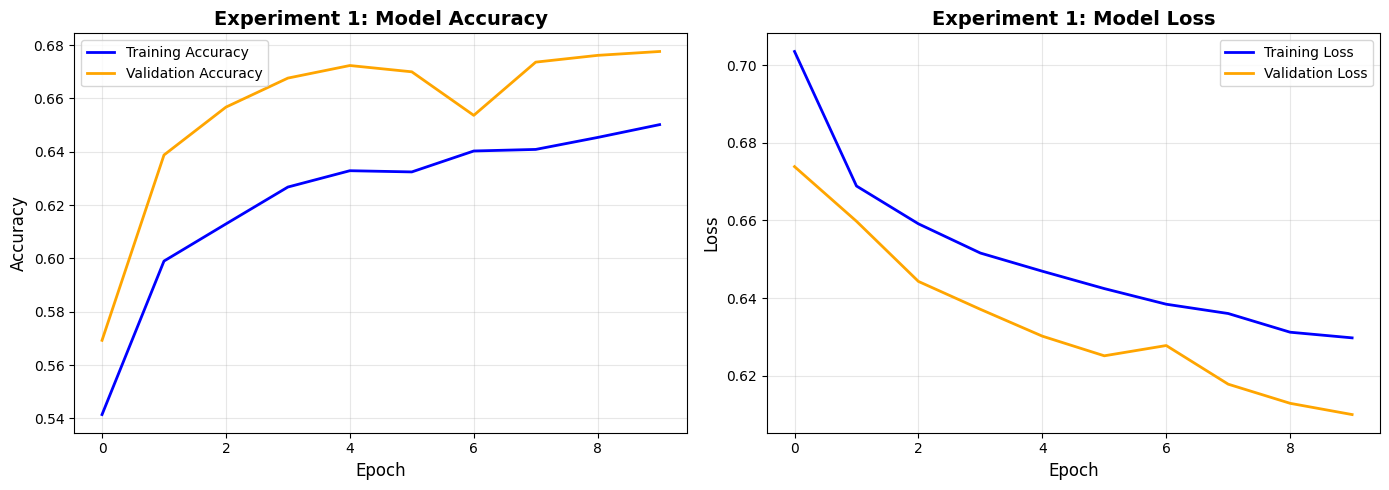

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(history_experiment1.history['accuracy'], label='Training Accuracy',
          linewidth=2, color='blue')
ax1.plot(history_experiment1.history['val_accuracy'], label='Validation Accuracy',
          linewidth=2, color='orange')
ax1.set_title('Experiment 1: Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(history_experiment1.history['loss'], label='Training Loss',
          linewidth=2, color='blue')
ax2.plot(history_experiment1.history['val_loss'], label='Validation Loss',
          linewidth=2, color='orange')
ax2.set_title('Experiment 1: Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Reset the validation generator
val_generator_exp1.reset()

# Get predictions (probabilities)
y_pred_proba_exp1 = model_experiment1.predict(val_generator_exp1, verbose=0)
print(f"Predictions shape: {y_pred_proba_exp1.shape}")

# Convert probabilities to classes (0 or 1)
# If probability > 0.5, predict infected (1), else healthy (0)
y_pred_classes_exp1 = (y_pred_proba_exp1 > 0.5).astype(int).flatten()

# Get true labels
y_true_exp1 = val_generator_exp1.classes

print(f" predictions for {len(y_true_exp1)} images")
print(f"True labels shape: {y_true_exp1.shape}")
print(f"Predicted classes shape: {y_pred_classes_exp1.shape}")

Predictions shape: (5512, 1)
 predictions for 5512 images
True labels shape: (5512,)
Predicted classes shape: (5512,)


In [ ]:
# Calculate detailed classification report
report_exp1 = classification_report(
    y_true_exp1,
    y_pred_classes_exp1,
    target_names=['Uninfected', 'Parasitized'],
    output_dict=True
)

# Extract metrics for infected class (Parasitized)
accuracy_exp1 = report_exp1['accuracy']
precision_exp1 = report_exp1['Parasitized']['precision']
recall_exp1 = report_exp1['Parasitized']['recall']
f1_exp1 = report_exp1['Parasitized']['f1-score']

# Calculate AUC (Area Under ROC Curve)
fpr_exp1, tpr_exp1, _ = roc_curve(y_true_exp1, y_pred_proba_exp1)
auc_exp1 = auc(fpr_exp1, tpr_exp1)

print("EXPERIMENT 1 RESULTS")
print(f"Accuracy:  {accuracy_exp1:.4f} ({accuracy_exp1*100:.2f}%)")
print(f"Precision: {precision_exp1:.4f} ({precision_exp1*100:.2f}%)")
print(f"Recall:    {recall_exp1:.4f} ({recall_exp1*100:.2f}%)")
print(f"F1-Score:  {f1_exp1:.4f}")
print(f"AUC:       {auc_exp1:.4f}")



EXPERIMENT 1 RESULTS
Accuracy:  0.6776 (67.76%)
Precision: 0.6721 (67.21%)
Recall:    0.6938 (69.38%)
F1-Score:  0.6827
AUC:       0.7331


##### Experiment  Confusion Matrix

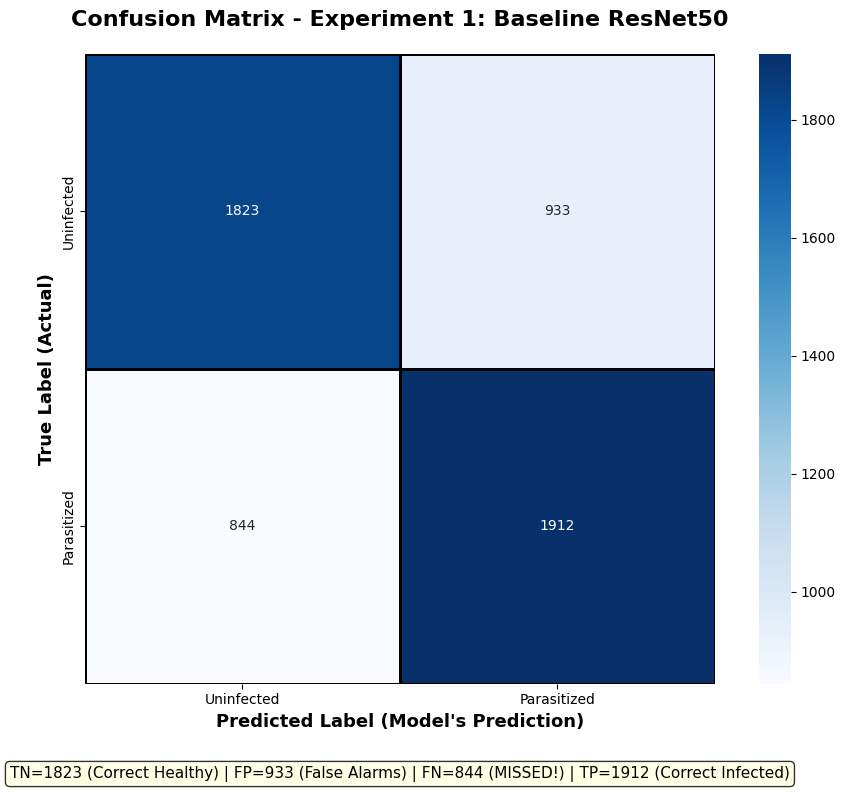


Interpretation:
  - True Negatives (TN): 1823 - Correctly identified healthy cells
  - False Positives (FP): 933 - Healthy cells wrongly called infected
  - False Negatives (FN): 844 - Infected cells wrongly called healthy (DANGEROUS!)
  - True Positives (TP): 1912 - Correctly identified infected cells


In [ ]:
confusion_matrix_exp1 = confusion_matrix(y_true_exp1, y_pred_classes_exp1)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_exp1, annot=True, fmt='d', cmap='Blues',
            cbar=True, square=True,
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'],
            linewidths=2, linecolor='black')

plt.title('Confusion Matrix - Experiment 1: Baseline ResNet50',
         fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label (Actual)', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label (Model\'s Prediction)', fontsize=13, fontweight='bold')

#  Explained text below
TN, FP, FN, TP = confusion_matrix_exp1.ravel()
plt.text(1, 2.3,
        f'TN={TN} (Correct Healthy) | FP={FP} (False Alarms) | '
        f'FN={FN} (MISSED!) | TP={TP} (Correct Infected)',
        ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"  - True Negatives (TN): {TN} - Correctly identified healthy cells")
print(f"  - False Positives (FP): {FP} - Healthy cells wrongly called infected")
print(f"  - False Negatives (FN): {FN} - Infected cells wrongly called healthy (DANGEROUS!)")
print(f"  - True Positives (TP): {TP} - Correctly identified infected cells")


##### ROC CURVE FOR EXPERIMENT 1

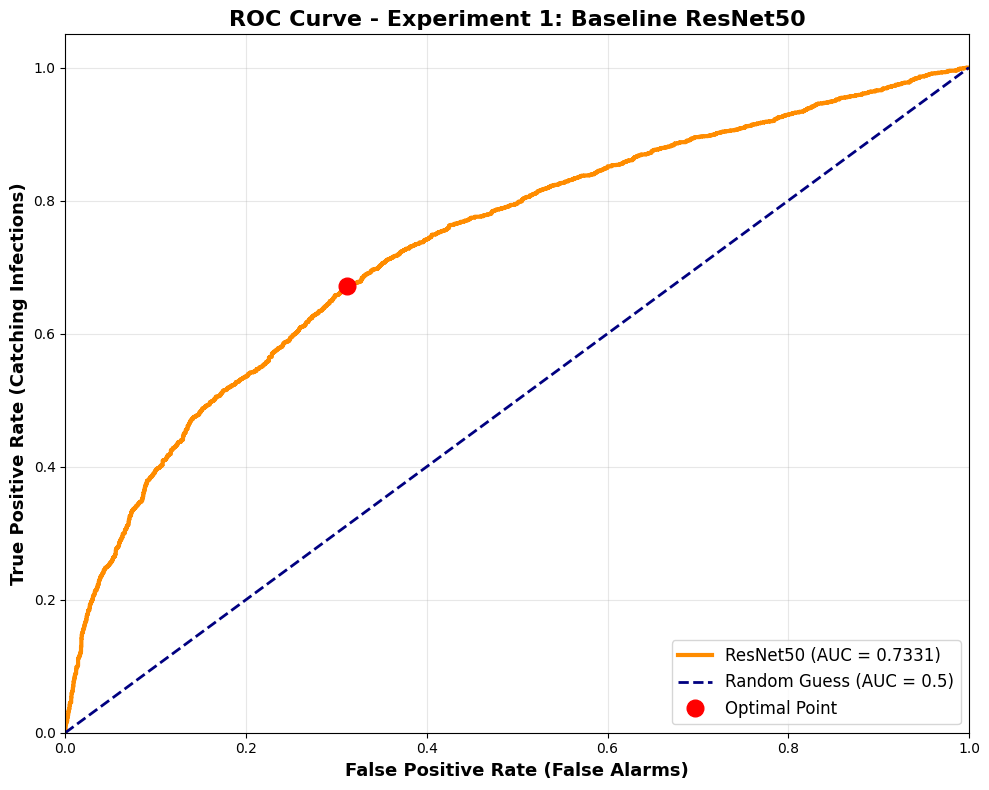

✓ ROC curve saved

AUC Score: 0.7331
  → ACCEPTABLE performance


In [ ]:
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr_exp1, tpr_exp1, color='darkorange', linewidth=3,
        label=f'ResNet50 (AUC = {auc_exp1:.4f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--',
        label='Random Guess (AUC = 0.5)')

# Mark optimal point (best balance)
optimal_idx = np.argmax(tpr_exp1 - fpr_exp1)
plt.plot(fpr_exp1[optimal_idx], tpr_exp1[optimal_idx], 'ro',
        markersize=12, label='Optimal Point')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alarms)', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (Catching Infections)', fontsize=13, fontweight='bold')
plt.title('ROC Curve - Experiment 1: Baseline ResNet50',
         fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ ROC curve saved")
print(f"\nAUC Score: {auc_exp1:.4f}")
if auc_exp1 > 0.9:
    print("  → EXCELLENT performance!")
elif auc_exp1 > 0.8:
    print("  → GOOD performance")
elif auc_exp1 > 0.7:
    print("  → ACCEPTABLE performance")
else:
    print("  → Needs improvement")

In [ ]:
new_row = pd.DataFrame([{
    'Experiment': 'Experiment 1',
    'Description': 'Baseline ResNet50 (All layers frozen)',
    'Accuracy': f'{accuracy_exp1:.4f}',
    'Precision': f'{precision_exp1:.4f}',
    'Recall': f'{recall_exp1:.4f}',
    'F1-Score': f'{f1_exp1:.4f}',
    'AUC': f'{auc_exp1:.4f}'
}])
results_table = pd.concat([results_table, new_row], ignore_index=True)

print("\nUpdated Results Table:")
print(results_table)


Updated Results Table:
     Experiment                            Description Accuracy Precision  \
0  Experiment 1  Baseline ResNet50 (All layers frozen)   0.6776    0.6721   

   Recall F1-Score     AUC  
0  0.6938   0.6827  0.7331  


#### Experiment 2



*   Fine Tuning(Unfreeze  layers)


  * Flips images horizontally and vertically
  * Zooms in/out up to 20%
  * Shifts images left/right/up/down
  *  Rotates images up to 20 degrees








In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen_exp3 = ImageDataGenerator(
        preprocessing_function=preprocess_input,

    rescale=1./255,
    rotation_range=20,        # Rotate up to 20 degrees
    width_shift_range=0.2,    # Shift horizontally 20%
    height_shift_range=0.2,   # Shift vertically 20%
    horizontal_flip=True,     # Flip left-right
    vertical_flip=True,       # Flip up-down
    zoom_range=0.2,           # Zoom in/out 20%
    shear_range=0.15,         # Shear transformation
    fill_mode='nearest'       # Fill empty pixels with nearest value
)

# Validation data NO augmentation (we evaluate on original images)
val_datagen_exp3 = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)

train_generator_exp3 = train_datagen_exp3.flow_from_directory(
    training_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator_exp3 = val_datagen_exp3.flow_from_directory(
    testing_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print(" Data augmentation ENABLED for training")
print(f"Training images: {train_generator_exp3.samples}")
print(f"Validation images: {val_generator_exp3.samples}")

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
 Data augmentation ENABLED for training
Training images: 22046
Validation images: 5512


##### Model 2 and training

In [ ]:
history_exp3 = model_exp3.fit(
    train_generator_exp3,
    epochs=10,
    validation_data=val_generator_exp3,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 333s 454ms/step - accuracy: 0.5748 - loss: 0.6783 - val_accuracy: 0.6508 - val_loss: 0.6124
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 299s 434ms/step - accuracy: 0.6958 - loss: 0.5747 - val_accuracy: 0.7342 - val_loss: 0.5486
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 298s 432ms/step - accuracy: 0.7377 - loss: 0.5199 - val_accuracy: 0.6731 - val_loss: 0.7565
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 298s 433ms/step - accuracy: 0.7452 - loss: 0.5043 - val_accuracy: 0.6889 - val_loss: 0.7120
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 298s 433ms/step - accuracy: 0.7574 - loss: 0.4870 - val_accuracy: 0.7622 - val_loss: 0.4890
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 299s 433ms/step - accuracy: 0.7691 - loss: 0.4761 - val_accuracy: 0.8220 - val_loss: 0.3867
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 299s 434ms/step - accuracy: 0.7708 - loss: 0.4685 - val_accuracy: 0.6698 - val_loss: 0.8439
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 298s 432ms/step - accuracy: 0.7839 -

##### Learning curves fro experiment 2

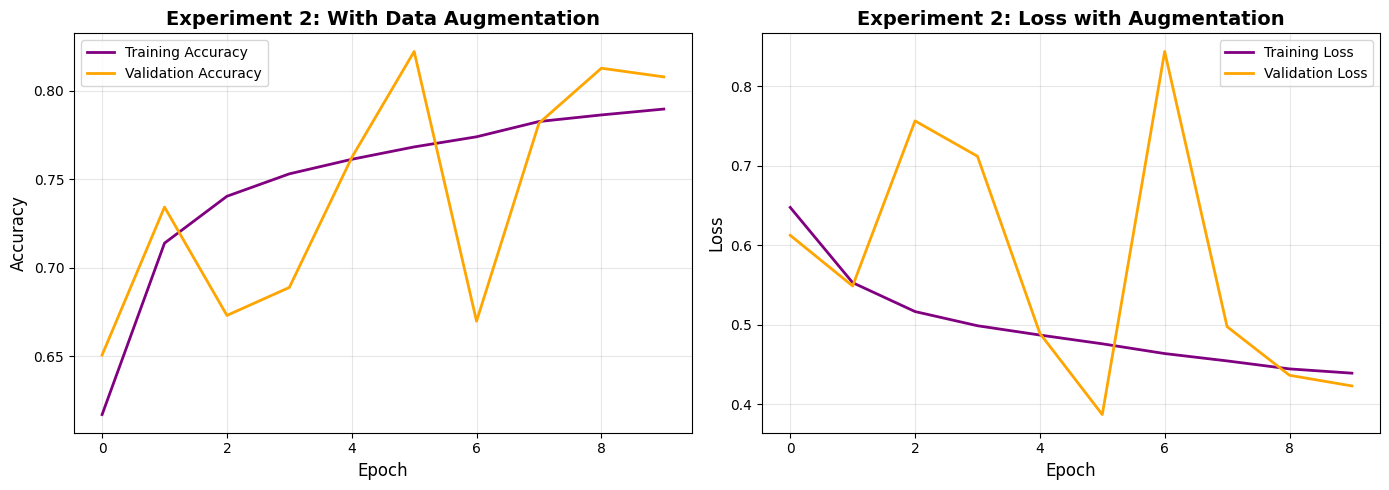

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_exp3.history['accuracy'], label='Training Accuracy',
          linewidth=2, color='purple')
ax1.plot(history_exp3.history['val_accuracy'], label='Validation Accuracy',
          linewidth=2, color='orange')
ax1.set_title('Experiment 2: With Data Augmentation', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_exp3.history['loss'], label='Training Loss',
          linewidth=2, color='purple')
ax2.plot(history_exp3.history['val_loss'], label='Validation Loss',
          linewidth=2, color='orange')
ax2.set_title('Experiment 2: Loss with Augmentation', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


##### Prediction , Confusion Matrix and ROC curves Experiment 2



EXPERIMENT 3 RESULTS
Accuracy:  0.8077 (80.77%)
Precision: 0.7363 (73.63%)
Recall:    0.9586 (95.86%)
F1-Score:  0.8329
AUC:       0.9190


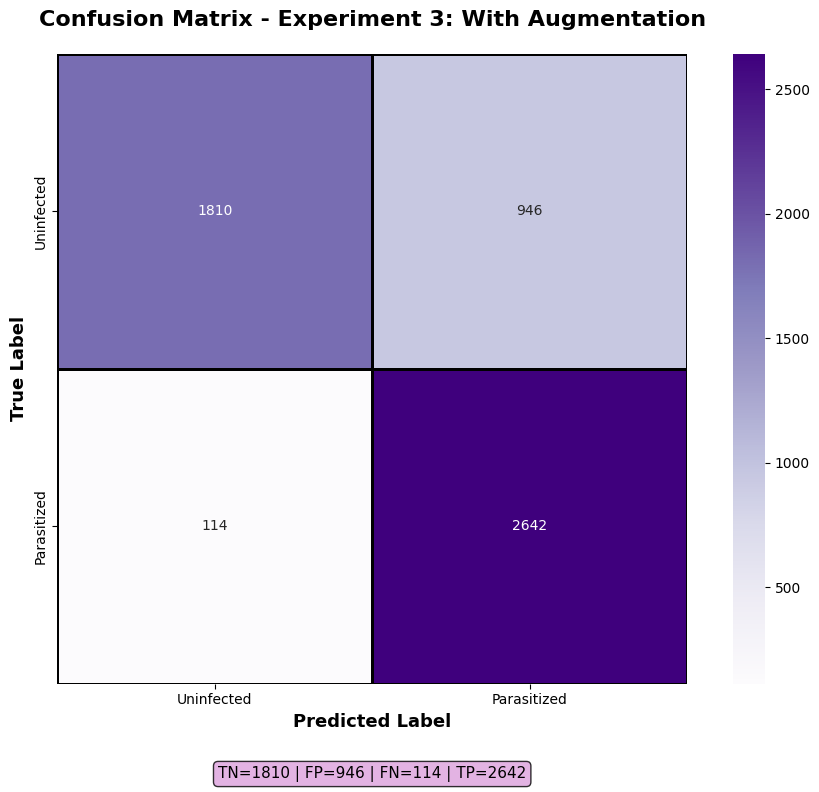

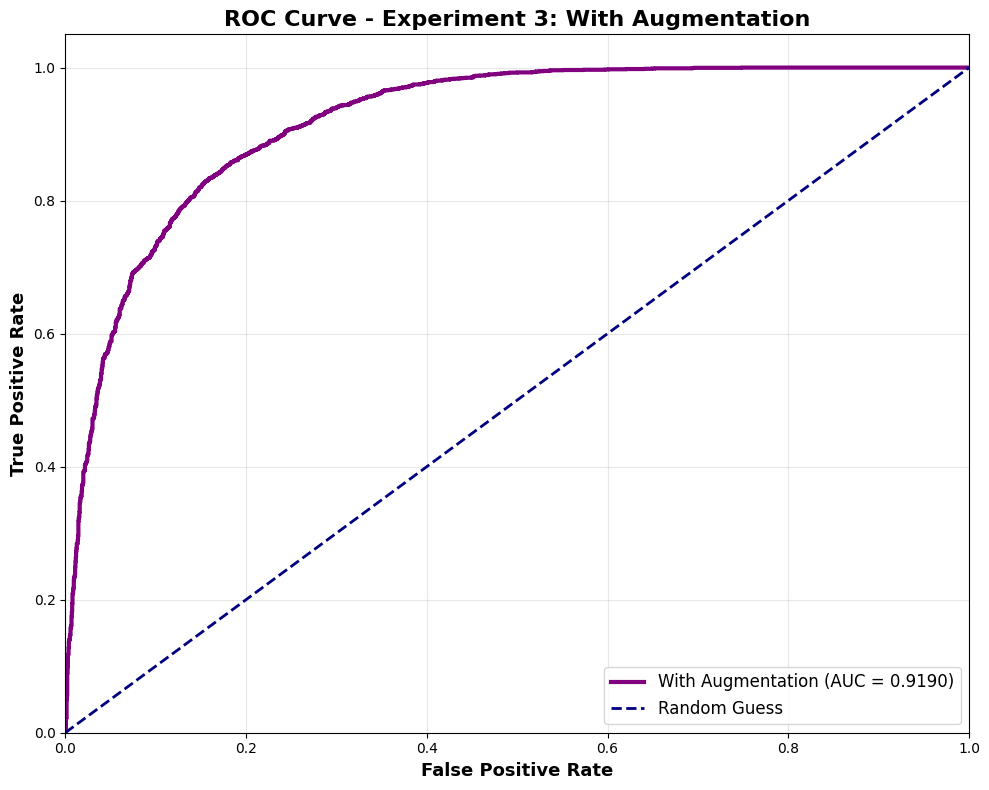

In [ ]:
# Get predictions
val_generator_exp3.reset()
y_pred_proba_exp3 = model_exp3.predict(val_generator_exp3, verbose=0)
y_pred_classes_exp3 = (y_pred_proba_exp3 > 0.5).astype(int).flatten()
y_true_exp3 = val_generator_exp3.classes

# Calculate metrics
report_exp3 = classification_report(
    y_true_exp3,
    y_pred_classes_exp3,
    target_names=['Uninfected', 'Parasitized'],
    output_dict=True
)

accuracy_exp3 = report_exp3['accuracy']
precision_exp3 = report_exp3['Parasitized']['precision']
recall_exp3 = report_exp3['Parasitized']['recall']
f1_exp3 = report_exp3['Parasitized']['f1-score']

fpr_exp3, tpr_exp3, _ = roc_curve(y_true_exp3, y_pred_proba_exp3)
auc_exp3 = auc(fpr_exp3, tpr_exp3)

print("EXPERIMENT 3 RESULTS")
print(f"Accuracy:  {accuracy_exp3:.4f} ({accuracy_exp3*100:.2f}%)")
print(f"Precision: {precision_exp3:.4f} ({precision_exp3*100:.2f}%)")
print(f"Recall:    {recall_exp3:.4f} ({recall_exp3*100:.2f}%)")
print(f"F1-Score:  {f1_exp3:.4f}")
print(f"AUC:       {auc_exp3:.4f}")

# Confusion Matrix
cm_exp3 = confusion_matrix(y_true_exp3, y_pred_classes_exp3)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_exp3, annot=True, fmt='d', cmap='Purples',
            cbar=True, square=True,
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'],
            linewidths=2, linecolor='black')
plt.title('Confusion Matrix - Experiment 3: With Augmentation',
         fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')

tn, fp, fn, tp = cm_exp3.ravel()
plt.text(1, 2.3, f'TN={tn} | FP={fp} | FN={fn} | TP={tp}',
        ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8))

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_exp3, tpr_exp3, color='purple', linewidth=3,
        label=f'With Augmentation (AUC = {auc_exp3:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--',
        label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curve - Experiment 3: With Augmentation',
         fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### ResNet50 Experiment 3


*   Unfreeze the last  15 layers
*   Use lower learning rate 0.0001


*   Less Data Augumentation






In [ ]:
train_datagen_exp2 = ImageDataGenerator(rescale=1./255,

                                         rotation_range=10,        # Reduced from 20
    width_shift_range=0.1,    # Reduced from 0.2
    height_shift_range=0.1,   # Reduced from 0.2
    horizontal_flip=True,
    zoom_range=0.)
val_datagen_exp2 = ImageDataGenerator(rescale=1./255)

train_generator_exp2 = train_datagen_exp2.flow_from_directory(
    training_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator_exp2 = val_datagen_exp2.flow_from_directory(
    testing_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print(f"Training images: {train_generator_exp2.samples}")
print(f"Validation images: {val_generator_exp2.samples}")

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Training images: 22046
Validation images: 5512


In [ ]:
# Load pre-trained ResNet50
base_model_exp2 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# First freeze all layers
base_model_exp2.trainable = True

#  freeze early layers, unfreeze last 15
for layer in base_model_exp2.layers[:-15]:
    layer.trainable = False

#  trainable layers
trainable_count = sum([1 for layer in base_model_exp2.layers if layer.trainable])
print(f" {trainable_count} layers are UNFROZEN for fine-tuning")

#  classification layers
x = base_model_exp2.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_exp2 = Model(inputs=base_model_exp2.input, outputs=predictions)

# Compile  LOWER learning rate
model_exp2.compile(
    optimizer=Adam(learning_rate=5e-5),  # * LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

trainable_params = sum([tf.size(w).numpy() for w in model_exp2.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")


 15 layers are UNFROZEN for fine-tuning
Trainable parameters: 6,045,185


In [ ]:
# Training with fine tuning
history_exp2 = model_exp2.fit(
    train_generator_exp2,
    epochs=5,
    validation_data=val_generator_exp2,
    verbose=1
)

print("Training end!")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
143/689 ━━━━━━━━━━━━━━━━━━━━ 3:41 405ms/step - accuracy: 0.5623 - loss: 0.6849

##### Learning curvers fro experiment 3

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_exp2.history['accuracy'], label='Training Accuracy',
          linewidth=2, color='green')
ax1.plot(history_exp2.history['val_accuracy'], label='Validation Accuracy',
          linewidth=2, color='red')
ax1.set_title('Experiment 3: Model Accuracy (Fine-tuned)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_exp2.history['loss'], label='Training Loss',
          linewidth=2, color='green')
ax2.plot(history_exp2.history['val_loss'], label='Validation Loss',
          linewidth=2, color='red')
ax2.set_title('Experiment 3: Model Loss (Fine-tuned)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


##### Prediction and metric for experiment 3

In [ ]:
val_generator_exp2.reset()
y_pred_proba_exp2 = model_exp2.predict(val_generator_exp2, verbose=0)
y_pred_classes_exp2 = (y_pred_proba_exp2 > 0.5).astype(int).flatten()
y_true_exp2 = val_generator_exp2.classes

# Calculate metrics
report_exp2 = classification_report(
    y_true_exp2,
    y_pred_classes_exp2,
    target_names=['Uninfected', 'Parasitized'],
    output_dict=True
)

accuracy_exp2 = report_exp2['accuracy']
precision_exp2 = report_exp2['Parasitized']['precision']
recall_exp2 = report_exp2['Parasitized']['recall']
f1_exp2 = report_exp2['Parasitized']['f1-score']

fpr_exp2, tpr_exp2, _ = roc_curve(y_true_exp2, y_pred_proba_exp2)
auc_exp2 = auc(fpr_exp2, tpr_exp2)

print("EXPERIMENT 3 ")
print(f"Accuracy:  {accuracy_exp2:.4f} ({accuracy_exp2*100:.2f}%)")
print(f"Precision: {precision_exp2:.4f} ({precision_exp2*100:.2f}%)")
print(f"Recall:    {recall_exp2:.4f} ({recall_exp2*100:.2f}%)")
print(f"F1-Score:  {f1_exp2:.4f}")
print(f"AUC:       {auc_exp2:.4f}")

# Compare to Experiment 2
print("\nCOMPARISON TO EXPERIMENT 2:")
print(f"Accuracy change: {accuracy_exp2 - accuracy_exp3:+.4f}")
print(f"Precision change: {precision_exp2 - precision_exp3:+.4f}")
print(f"Recall change: {recall_exp2 - recall_exp3:+.4f}")
print(f"F1-Score change: {f1_exp2 - f1_exp3:+.4f}")
print(f"AUC change: {auc_exp2 - auc_exp3:+.4f}")

##### Confusion Matrix for Experiment 3

In [ ]:
cm_exp2 = confusion_matrix(y_true_exp2, y_pred_classes_exp2)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_exp2, annot=True, fmt='d', cmap='Greens',
            cbar=True, square=True,
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'],
            linewidths=2, linecolor='black')

plt.title('Confusion Matrix - Experiment 3: Fine-tuned ResNet50',
         fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')

tn, fp, fn, tp = cm_exp2.ravel()
plt.text(1, 2.3,
        f'TN={tn} | FP={fp} | FN={fn} | TP={tp}',
        ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

##### ROC Curve for experiment 3

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(fpr_exp2, tpr_exp2, color='green', linewidth=3,
        label=f'Fine-tuned ResNet50 (AUC = {auc_exp2:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--',
        label='Random Guess (AUC = 0.5)')

optimal_idx = np.argmax(tpr_exp2 - fpr_exp2)
plt.plot(fpr_exp2[optimal_idx], tpr_exp2[optimal_idx], 'ro',
        markersize=12, label='Optimal Point')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curve - Experiment 3: Fine-tuned ResNet50',
         fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
new_row = pd.DataFrame([{
    'Experiment': 'Experiment 3',
    'Description': 'Fine-tuned last 30 layers',
    'Accuracy': f'{accuracy_exp2:.4f}',
    'Precision': f'{precision_exp2:.4f}',
    'Recall': f'{recall_exp2:.4f}',
    'F1-Score': f'{f1_exp2:.4f}',
    'AUC': f'{auc_exp2:.4f}'
}])
results_table = pd.concat([results_table, new_row], ignore_index=True)

print("\nUpdated Results Table:")
print(results_table)

In [ ]:
print(results_table.to_string(index=False))


###